# Mask R-CNN - Train on Shapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# del dataset_train,dataset_val
# del model
# gc.collect()
# sess = KB.get_session()
# sess.close()
# import tensorflow as tf
# # print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__))
# dir(tf)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import  gc
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pprint
import keras.backend as KB
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 
# from mrcnn.pc_layer    import PCTensor
# from mrcnn.pc_layer   import PCNLayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100)

# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 6                    #Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 6
config.STEPS_PER_EPOCH = 2
# config.IMAGES_PER_GPU  = 1
config.FCN_INPUT_SHAPE = config.IMAGE_SHAPE[0:2]
config.display() 

# Build shape dataset        -----------------------------------------------

from mrcnn.datagen import data_generator, load_image_gt

# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print(' COCO Model Path       : ', COCO_MODEL_PATH)
print(' Checkpoint folder Path: ', MODEL_DIR)

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.6.0   Keras Version : 2.1.3 

Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FCN_INPUT_SHAPE                [128 128]
GPU_COUNT                      1
IMAGES_PER_GPU                 6
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE        

## Process outside of training 

### Create Model

In [34]:
try :
    del model, train_generator, val_generator, mm
    gc.collect()
except: 
    pass

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
#model.keras_model.summary(line_length = 120) 

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that are different due to the different number of classes
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)

model.compile_only(learning_rate=config.LEARNING_RATE, layers='heads')
KB.set_learning_phase(1)

>>> Set_log_dir() -- model dir is  E:\Models\mrcnn_logs
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180413T1445\mask_rcnn_shapes_{epoch:04d}.h5
>>> Generate pyramid anchors 
    Size of anchor array is : (4092, 4)
>>> RPN Outputs  <class 'list'>
      rpn_class_logits_31/concat:0
      rpn_class_31/concat:0
      rpn_bbox_31/concat:0
>>> Proposal Layer init complete. Size of anchors:  (4092, 4)
     Scores :  (6, 4092)
     Deltas :  (6, 4092, 4)
     Anchors:  (6, 4092, 4)
     Boxes shape / type after processing:  (6, 4092, 4) <class 'tensorflow.python.framework.ops.Tensor'>
>>> Detection Target Layer : initialization
>>> Detection Target Layer : call  <class 'list'> 4
     proposals.shape    : (6, ?, ?) <class 'tensorflow.python.framework.ops.Tensor'>
     gt_class_ids.shape : (?, ?) <class 'tensorflow.python.framework.ops.Tensor'>
     gt_bboxes.shape    : (?, ?, 4) <class 'tensorflow.python.framework.ops.Tensor'>
     gt_masks.shape     : (?, 56, 56, ?) 

InvalidArgumentError: You must feed a value for placeholder tensor 'input_image_31' with dtype float and shape [?,128,128,3]
	 [[Node: input_image_31 = Placeholder[dtype=DT_FLOAT, shape=[?,128,128,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: proposal_rois_31/strided_slice_115/_87 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2878_proposal_rois_31/strided_slice_115", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_image_31', defined at:
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-b41d4c68568c>", line 7, in <module>
    model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
  File "..\mrcnn\model.py", line 97, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "..\mrcnn\model.py", line 121, in build
    input_image      = KL.Input(shape=config.IMAGE_SHAPE.tolist(), name="input_image")
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\engine\topology.py", line 1455, in Input
    input_tensor=tensor)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\engine\topology.py", line 1364, in __init__
    name=self.name)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 504, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1746, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 4026, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_image_31' with dtype float and shape [?,128,128,3]
	 [[Node: input_image_31 = Placeholder[dtype=DT_FLOAT, shape=[?,128,128,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: proposal_rois_31/strided_slice_115/_87 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2878_proposal_rois_31/strided_slice_115", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


###  Print some model information 

In [ ]:

# mm = model.keras_model
# print('\n Learning phase values is L ' ,KB.learning_phase())
# print('\n Metrics (_get_deduped_metrics_names():) ') 
# pp.pprint(mm._get_deduped_metrics_names())
# print('\n Outputs: ') 
# pp.pprint(mm.outputs)
# print('\n Losses (model.metrics_names): ') 
# pp.pprint(mm.metrics_names)

# model.keras_model.summary(line_length = 120) 

### Define Data Generator

In [6]:
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

### Get next shapes from generator and display loaded shapes

In [7]:
train_batch_x, train_batch_y = next(train_generator)

>>> Generate pyramid anchors 
    Size of anchor array is : (4092, 4)


### Display loaded shapes

Image id:  153
Image meta [153 128 128   3   0   0 128 128   1   1   1   1]
[3 3]


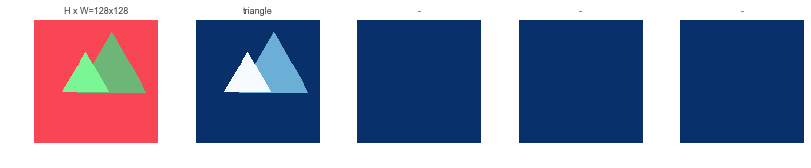

Image id:  484
Image meta [484 128 128   3   0   0 128 128   1   1   1   1]
[1 2]


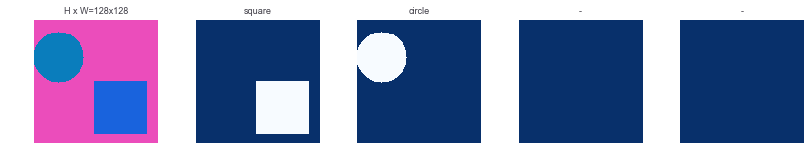

Image id:  52
Image meta [ 52 128 128   3   0   0 128 128   1   1   1   1]
[1 3]


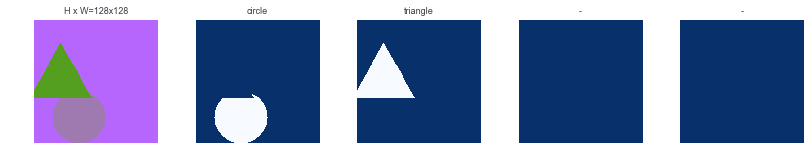

Image id:  294
Image meta [294 128 128   3   0   0 128 128   1   1   1   1]
[2]


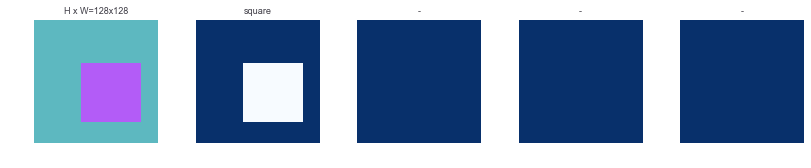

Image id:  236
Image meta [236 128 128   3   0   0 128 128   1   1   1   1]
[3 1 3]


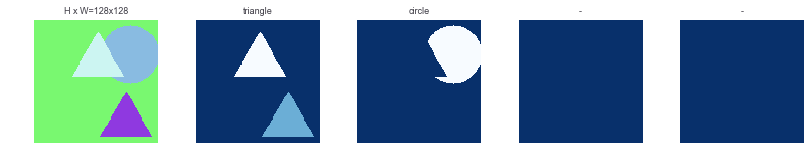

Image id:  198
Image meta [198 128 128   3   0   0 128 128   1   1   1   1]
[1 1 2 1]


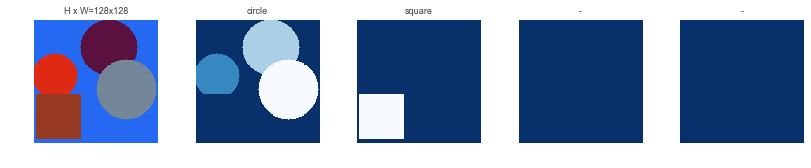

In [8]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)



In [ ]:
# from   mrcnn.utils            import parse_image_meta_graph
# a,b,c,d = parse_image_meta_graph(img_meta)

### Push Data thru model using get_layer_output()

In [9]:
from mrcnn.callbacks import get_layer_output_1,get_layer_output_2
np.set_printoptions(linewidth=100,precision=4)
pp = pprint.PrettyPrinter(indent=4)

In [10]:
layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1)


/* Inputs */
Input 0:  (input_image             ) 	  Input shape: (6, 128, 128, 3)
Input 1:  (input_image_meta        ) 	  Input shape: (6, 12)
Input 2:  (input_rpn_match         ) 	  Input shape: (6, 4092, 1)
Input 3:  (input_rpn_bbox          ) 	  Input shape: (6, 256, 4)
Input 4:  (input_gt_class_ids      ) 	  Input shape: (6, 100)
Input 5:  (input_gt_boxes          ) 	  Input shape: (6, 100, 4)
Input 6:  (input_gt_masks          ) 	  Input shape: (6, 56, 56, 100)
gt_c;ass_ids shape :  (6, 100) 	 norm_gt_bboxes.shape :  (6, 100, 4)

 [[3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [18]:
for i in range(100):
    train_batch_x, train_batch_y = next(train_generator)

    layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1, verbose = False)

    pt   = layers_out[8]   # pred_tensor
    pcc  = layers_out[9]   # pred_cls_cnt

    pt2  = layers_out[12]  # pred_TNESOR_2
    pcc2 = layers_out[13]  # pred_cls_cnt_2

    # print( pt2.shape, pcc2.shape)
    # print( pt.shape, pcc.shape)
    # print(pc2)

    for img in range(config.BATCH_SIZE):
        for cls in range(4):
        #     print(pt2[img][cls])
        #     print(pt[img][cls])
            equal = np.all(pt2[img][cls]== pt[img][cls,:,:7], axis = -1)

            if (~equal.all()):
                print(' Iteration', i , 'Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
                print(equal)
                print('\n -- using numpy \n',pt[img][cls,~equal,:-1])
                print('\n -- using tensorflow \n',pt2[img][cls,~equal])
                print()
    #             print('\n -- using numpy \n',pt[img][cls])            
    #             print('\n -- using tensorflow \n',pt2[img][cls])
    

 Iteration 0 Image  2  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  10.  80.  75. 128.   1.]
 [  1.   1.  75.  52. 124. 101.   1.]]

 -- using tensorflow 
 [[  2.   1.  75.  52. 124. 101.   1.]
 [  0.   1.  10.  80.  75. 128.   1.]]

 Iteration 0 Image  2  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  

 Iteration 3 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[ 0.  1. 34.  5. 81. 52.  1.]]

 -- using tensorflow 
 [[ 1.  1. 34.  5. 81. 52.  1.]]

 Iteration 3 Image  1  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True 

 Iteration 5 Image  0  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  20.  11.  77.  68.   2.]
 [  1.   1.  64.  52. 125. 113.   2.]]

 -- using tensorflow 
 [[  1.   1.  64.  52. 125. 113.   2.]
 [  0.   1.  20.  11.  77.  68.   2.]]

 Iteration 5 Image  1  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  

 Iteration 8 Image  2  Class  2  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[ 0.  1.  8. 15. 49. 56.  2.]]

 -- using tensorflow 
 [[ 1.  1.  8. 15. 49. 56.  2.]]

 Iteration 8 Image  3  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True 

 Iteration 11 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  57.  28. 109.  80.   1.]]

 -- using tensorflow 
 [[  1.   1.  57.  28. 109.  80.   1.]]

 Iteration 11 Image  0  Class  2  ALL EQUAL:  False
[False False False  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 13 Image  0  Class  2  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  48.  77.  93. 122.   2.]]

 -- using tensorflow 
 [[  1.   1.  48.  77.  93. 122.   2.]]

 Iteration 13 Image  1  Class  1  ALL EQUAL:  False
[False  True False  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 15 Image  2  Class  1  ALL EQUAL:  False
[False  True False  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[ 0.  1. 45.  0. 93. 47.  1.]
 [ 2.  1. 42. 41. 87. 86.  1.]]

 -- using tensorflow 
 [[ 2.  1. 42. 41. 87. 86.  1.]
 [ 0.  1. 45.  0. 93. 47.  1.]]

 Iteration 15 Image  4  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  T

 Iteration 18 Image  0  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  11.  27.  38.  71.   1.]
 [  1.   1.  22.  41.  85. 104.   1.]]

 -- using tensorflow 
 [[  2.   1.  22.  41.  85. 104.   1.]
 [  0.   1.  11.  27.  38.  71.   1.]]

 Iteration 18 Image  0  Class  2  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 21 Image  0  Class  2  ALL EQUAL:  False
[False  True False  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  74.   5. 121.  52.   2.]
 [  2.   1.  26.  14.  91.  79.   2.]]

 -- using tensorflow 
 [[  2.   1.  26.  14.  91.  79.   2.]
 [  0.   1.  74.   5. 121.  52.   2.]]

 Iteration 21 Image  4  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 24 Image  3  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  72.  14. 127.  78.   3.]]

 -- using tensorflow 
 [[  1.   1.  72.  14. 127.  78.   3.]]

 Iteration 24 Image  4  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 27 Image  0  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  64.  69. 117. 128.   3.]]

 -- using tensorflow 
 [[  1.   1.  64.  69. 117. 128.   3.]]

 Iteration 27 Image  3  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 30 Image  0  Class  3  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.   0.  71.  61. 128.   3.]
 [  1.   1.  10.  23.  61.  81.   3.]]

 -- using tensorflow 
 [[  1.   1.  10.  23.  61.  81.   3.]
 [  0.   1.   0.  71.  61. 128.   3.]]

 Iteration 30 Image  2  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 32 Image  0  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  25.  22.  84.  81.   2.]
 [  1.   1.  74.  61. 125. 112.   2.]]

 -- using tensorflow 
 [[  2.   1.  74.  61. 125. 112.   2.]
 [  0.   1.  25.  22.  84.  81.   2.]]

 Iteration 32 Image  0  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 34 Image  0  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  51.  81.  98. 128.   1.]
 [  1.   1.  70.  24. 119.  73.   1.]]

 -- using tensorflow 
 [[  3.   1.  70.  24. 119.  73.   1.]
 [  1.   1.  51.  81.  98. 128.   1.]]

 Iteration 34 Image  0  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 37 Image  0  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  12.  38.  59.  85.   2.]
 [  1.   1.  72.  60. 128. 117.   2.]]

 -- using tensorflow 
 [[  2.   1.  72.  60. 128. 117.   2.]
 [  1.   1.  12.  38.  59.  85.   2.]]

 Iteration 37 Image  2  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 40 Image  1  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  72.   0. 127.  54.   1.]]

 -- using tensorflow 
 [[  1.   1.  72.   0. 127.  54.   1.]]

 Iteration 40 Image  1  Class  3  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 43 Image  0  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  44.  30. 109. 104.   3.]]

 -- using tensorflow 
 [[  1.   1.  44.  30. 109. 104.   3.]]

 Iteration 43 Image  2  Class  3  ALL EQUAL:  False
[False  True False  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 46 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  83.  58. 128. 105.   1.]]

 -- using tensorflow 
 [[  2.   1.  83.  58. 128. 105.   1.]]

 Iteration 46 Image  0  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 48 Image  2  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  18.  56.  63. 101.   1.]
 [  1.   1.  84.  27. 125.  68.   1.]]

 -- using tensorflow 
 [[  1.   1.  84.  27. 125.  68.   1.]
 [  0.   1.  18.  56.  63. 101.   1.]]

 Iteration 48 Image  2  Class  2  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 51 Image  0  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.   7.  45.  68. 106.   2.]
 [  1.   1.   3.  11.  52.  60.   2.]]

 -- using tensorflow 
 [[  1.   1.   3.  11.  52.  60.   2.]
 [  0.   1.   7.  45.  68. 106.   2.]]

 Iteration 51 Image  0  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 53 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.   0.  60.  59. 119.   1.]]

 -- using tensorflow 
 [[  1.   1.   0.  60.  59. 119.   1.]]

 Iteration 53 Image  1  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 56 Image  3  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  30.  28.  95.  93.   2.]
 [  1.   1.  16.  66.  81. 128.   2.]]

 -- using tensorflow 
 [[  2.   1.  16.  66.  81. 128.   2.]
 [  1.   1.  30.  28.  95.  93.   2.]]

 Iteration 56 Image  4  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 59 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[ 0.  1.  2. 13. 63. 72.  1.]]

 -- using tensorflow 
 [[ 1.  1.  2. 13. 63. 72.  1.]]

 Iteration 59 Image  0  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  Tru

 Iteration 61 Image  0  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[ 0.  1.  5.  2. 70. 67.  2.]
 [ 1.  1. 43. 19. 98. 74.  2.]]

 -- using tensorflow 
 [[ 2.  1. 43. 19. 98. 74.  2.]
 [ 1.  1.  5.  2. 70. 67.  2.]]

 Iteration 61 Image  0  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  T

 Iteration 63 Image  0  Class  2  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  65.  41. 108.  84.   2.]]

 -- using tensorflow 
 [[  2.   1.  65.  41. 108.  84.   2.]]

 Iteration 63 Image  0  Class  3  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 65 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  47.  61. 102. 116.   1.]]

 -- using tensorflow 
 [[  1.   1.  47.  61. 102. 116.   1.]]

 Iteration 65 Image  1  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 67 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  51.   9. 114.  72.   1.]]

 -- using tensorflow 
 [[  1.   1.  51.   9. 114.  72.   1.]]

 Iteration 67 Image  1  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 70 Image  0  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  36.   0. 101.  60.   3.]]

 -- using tensorflow 
 [[  1.   1.  36.   0. 101.  60.   3.]]

 Iteration 70 Image  1  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 73 Image  1  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.   0.  73.  48. 126.   1.]]

 -- using tensorflow 
 [[  1.   1.   0.  73.  48. 126.   1.]]

 Iteration 73 Image  5  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 76 Image  0  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.   4.   5.  51.  52.   2.]
 [  1.   1.  47.  53. 104. 110.   2.]]

 -- using tensorflow 
 [[  2.   1.  47.  53. 104. 110.   2.]
 [  1.   1.   4.   5.  51.  52.   2.]]

 Iteration 76 Image  1  Class  2  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 79 Image  3  Class  2  ALL EQUAL:  False
[False False False False  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  59.   1. 114.  43.   2.]
 [  1.   1.  36.  43.  95. 102.   2.]
 [  2.   1.  75.  43. 128. 100.   2.]
 [  3.   1.   5.  71.  56. 122.   2.]]

 -- using tensorflow 
 [[  3.   1.   5.  71.  56. 122.   2.]
 [  2.   1.  75.  43. 128. 100.   2.]
 [  1.   1.  36.  43.  95. 102.   2.]
 [  0.   1.  59.   1. 114.  43

 Iteration 82 Image  1  Class  2  ALL EQUAL:  False
[False  True False  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.   0.  59.  49. 114.   2.]
 [  2.   1.  75.  52. 128. 107.   2.]]

 -- using tensorflow 
 [[  2.   1.  75.  52. 128. 107.   2.]
 [  0.   1.   0.  59.  49. 114.   2.]]

 Iteration 82 Image  1  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 84 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[ 0.  1. 26. 32. 73. 78.  1.]]

 -- using tensorflow 
 [[ 2.  1. 26. 32. 73. 78.  1.]]

 Iteration 84 Image  0  Class  2  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  Tru

 Iteration 86 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[ 0.  1. 29. 14. 80. 65.  1.]]

 -- using tensorflow 
 [[ 1.  1. 29. 14. 80. 65.  1.]]

 Iteration 86 Image  0  Class  3  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  Tru

 Iteration 88 Image  0  Class  2  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  47.  58.  98. 109.   2.]]

 -- using tensorflow 
 [[  2.   1.  47.  58.  98. 109.   2.]]

 Iteration 88 Image  0  Class  3  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 90 Image  1  Class  1  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  83.  81. 128. 128.   1.]
 [  1.   1.  69.   7. 116.  54.   1.]]

 -- using tensorflow 
 [[  2.   1.  69.   7. 116.  54.   1.]
 [  1.   1.  83.  81. 128. 128.   1.]]

 Iteration 91 Image  1  Class  3  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 93 Image  0  Class  2  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  71.  73. 122. 124.   2.]]

 -- using tensorflow 
 [[  2.   1.  71.  73. 122. 124.   2.]]

 Iteration 93 Image  0  Class  3  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

 Iteration 95 Image  2  Class  3  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  17.  36.  76.  89.   3.]
 [  1.   1.  42.  68.  85. 118.   3.]]

 -- using tensorflow 
 [[  2.   1.  42.  68.  85. 118.   3.]
 [  1.   1.  17.  36.  76.  89.   3.]]

 Iteration 95 Image  3  Class  1  ALL EQUAL:  False
[False  True False  True  True  True  True  True  True  True  True  True  True  True  True

 Iteration 97 Image  0  Class  1  ALL EQUAL:  False
[False  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  84.   0. 125.  41.   1.]]

 -- using tensorflow 
 [[  3.   1.  84.   0. 125.  41.   1.]]

 Iteration 97 Image  0  Class  2  ALL EQUAL:  False
[False  True False  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  T

In [11]:
pt   = layers_out[6]   # pred_tensor
pcc  = layers_out[7]   # pred_cls_cnt

pt2  = layers_out[10]  # pred_TNESOR_2
pcc2 = layers_out[11]  # pred_cls_cnt_2


# print( pt2.shape, pcc2.shape)
# print( pt.shape, pcc.shape)
# print(pc2)

for img in range(config.BATCH_SIZE):
    for cls in range(4):
#         print(pt2[img][cls])
#         print(pt[img][cls])
        equal = np.all(pt2[img][cls]== pt[img][cls,:,:7], axis = -1)


        if (~equal.all()):
            print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
            print(equal)
            print('\n -- using numpy \n',pt[img][cls,~equal,:-1])
            print('\n -- using tensorflow \n',pt2[img][cls,~equal])
            print()
#             print('\n -- using numpy \n',pt[img][cls])            
#             print('\n -- using tensorflow \n',pt2[img][cls])
    

Image  0  Class  0  ALL EQUAL:  False
[ True False False  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]

 -- using numpy 
 [[31.  1.  0.  0.  0.  0.  0.]
 [30.  1.  0.  0.  0.  0.  0.]]

 -- using tensorflow 
 [[30.  1.  0.  0.  0.  0.  0.]
 [31.  1.  0.  0.  0.  0.  0.]]

Image  2  Class  0  ALL EQUAL:  False
[ True  True  True  True  True False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]

 -- using numpy 
 [[31.      0.9999  0.      0.      0.      0.      0.    ]
 [30.      0.9999  0.      0.      0.      0.      0.    ]]

 -- using tensorflow 
 [[30.      0.9999  0.      0.      0.      0.      0.    ]
 [31.      0.9999  0.      0.      0.      0.      0.    ]]

Image  3  Class  0  ALL EQUAL:  False
[ True  True False False  True  True  True  

In [14]:
pt   = layers_out[8]   # pred_tensor
pcc  = layers_out[9]   # pred_cls_cnt

pt2  = layers_out[12]  # pred_TNESOR_2
pcc2 = layers_out[13]  # pred_cls_cnt_2

# print( pt2.shape, pcc2.shape)
# print( pt.shape, pcc.shape)
# print(pc2)

for img in range(config.BATCH_SIZE):
    for cls in range(4):
        equal = np.all(pt2[img][cls]== pt[img][cls,:,:7], axis = -1)
        
#         print('\n -- using numpy \n',pt[img][cls])            
#         print('\n -- using tensorflow \n',pt2[img][cls])
        print( 'Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
        if (~equal.all()):
            print( 'Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
            print(equal)
            print('\n -- using numpy \n',pt[img][cls,~equal,:-1])
            print('\n -- using tensorflow \n',pt2[img][cls,~equal])
            print()
#             print('\n -- using numpy \n',pt[img][cls])            
#             print('\n -- using tensorflow \n',pt2[img][cls])
    

Image  0  Class  0  ALL EQUAL:  True
Image  0  Class  1  ALL EQUAL:  True
Image  0  Class  2  ALL EQUAL:  True
Image  0  Class  3  ALL EQUAL:  False
Image  0  Class  3  ALL EQUAL:  False
[False False  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]

 -- using numpy 
 [[  0.   1.  13.  44.  76. 116.   3.]
 [  1.   1.  34.  29.  75.  77.   3.]]

 -- using tensorflow 
 [[  1.   1.  34.  29.  75.  77.   3.]
 [  0.   1.  13.  44.  76. 116.   3.]]

Image  

In [ ]:
out_rois = layers_out[0]
out_rois[0] * np.array([128,128,128,128])  

In [ ]:
imgmeta_idx = mm.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Plot mask in string format

In [ ]:
# np.set_printoptions(threshold=99999, linewidth=2000)
# print(np.array2string(mask[...,0],max_line_width=2000,separator=''))
 

In [ ]:
outmask0 = layers_out[14][0,:,:,:,1] ##  mrcnn_mask
np.max(outmask0)

### Plot Predicition Probability Tensors

In [ ]:
%matplotlib notebook
from mrcnn.visualize import plot_gaussian
Zout = layers_out[1]
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout[img,cls], title = ttl)

### Plot Ground Truth Probability tensors

In [ ]:
# i = 1
# print(layers_out[i].shape)      #[0,0,0:20, 0:20]
Zout = layers_out[2]
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout[img,cls], title = ttl)

### Display predicted bounding boxes - calculate center and width/height of bboxes displayed 

In [ ]:
from mrcnn.utils import trim_zeros
np.set_printoptions( edgeitems=32, suppress=True)
pred_bb = layers_out[3]
print(pred_bb.shape)
x0 = [ trim_zeros((pred_bb[0,i,:,:])) for i in range(4)]
ps0 = np.concatenate( x0, axis=0 )

x1 = [ trim_zeros((pred_bb[1,i,:,:])) for i in range(4)]
ps1 = np.concatenate( x1, axis=0 )
# print(np.concatenate( x1, axis=0 ))
print(ps0)
print(ps0.shape)
width  = ps0[:,5] - ps0[:,3]
height = ps0[:,4] - ps0[:,2]
cx     = ps0[:,3] + ( width  / 2.0)
cy     = ps0[:,2] + ( height / 2.0)
means0  = np.stack((cx,cy,width, height),axis = -1)
print(means0)

#### Output RoIs (Normalized)

In [ ]:
output_rois = layers_out[0]
output_rois[0,:,:]

In [ ]:
# from mrcnn.pc_layer import PCTensor
# np.set_printoptions(precision=4,edgeitems=32)
# pc_tensor = PCTensor(model)
# pc_tensor.build_predictions(train_batch_x)
# # pc_tensor.pred_tensor[1]
# pc_tensor.pred_stacked[0]

### Display ground truth bboxes from Shapes database (using load_image_gt)

Here we are displaying the ground truth bounding boxes as provided by the dataset

In [ ]:
image_id = img_meta[0,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
visualize.draw_boxes(p_original_image, p_gt_bbox)

image_id = img_meta[1,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox)
visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display bboxes from Ground Truth Info - Input info Passed to Network 

layers_out[5]  gt_tensor is based on input_gt_class_ids and input_normlzd_gt_boxes

Display the Ground Truth bounding boxes from the tensor we've constructed

In [ ]:
np.set_printoptions(linewidth=120, precision=5)
gt_bboxes = layers_out[5]  
print(layers_out[5].shape)
print(' gt_cls_cnt')
print(layers_out[6])
print(layers_out[5][1,3])

In [ ]:
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 0
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
gt_bboxes = layers_out[5]
print(gt_bboxes.shape)
print(gt_bboxes[0,1,0:1,2:6])
print(gt_bboxes[0,2,0:2,2:6])
gt_bb = np.vstack((gt_bboxes[0,1,0:1,2:6],gt_bboxes[0,2,0:2,2:6],gt_bboxes[0,3,0:2,2:6]))
gt_bb.shape
visualize.draw_boxes(p_image, gt_bb)

## Display RoI proposals generated

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle -3

In [ ]:
img = 0
cls = 3  # <==== Class to dispaly
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)

pred_tensor = layers_out[3]
caps = [str(cls)+'-'+str(x) for x in pred_tensor[img,cls,:,0].astype('int16').tolist() ]
print(caps)
# print(pc_tensor.pred_tensor[1,3,:])
# print(pc_tensor.pred_tensor[1,3,:,2:6])
visualize.draw_boxes(p_image, pred_tensor[img,cls,:,2:6], captions = caps)

For each class:
- determine the center of each bounding box.
- center a 2d gaussian distribution with the mean = center of bounding box and sigma = height/width
- place dist on mesh grid
- normalize
- draw heatmap

In [ ]:
np.set_printoptions(precision=5)
from mrcnn.pc_layer import PCTensor
pc_tensor = PCTensor(model)
pc_tensor.build_predictions(sample_x)
print(pc_tensor.pred_stacked)    # list of tensors


### Plot Image 0

In [ ]:
from mrcnn.visualize import plot_gaussian
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
for img in range(num_images):
    for cls in range(num_classes):
        ttl = 'image :  {} class: {} '.format(img,cls)
        plot_gaussian(Zout1[img,cls], title = ttl)

### Plot Image 1

In [ ]:
# img = 0
# cls = 0
# _cnt = pc_tensor.pred_cls_cnt[img,cls]
# print(_cnt)
# for box in range(_cnt):

#     mns = means[img,cls, 0 : _cnt]
#     print('img: ',img, 'class: ', cls, 'class count: ',_cnt, 'shape of mns :',mns.shape)
#     # print('** bbox is : ' ,self.pred_tensor[img,cls,box])
#     # print('    center is ({:4f},{:4f})  width is {:4f} height is {:4f} '\
#         # .format(mns[0],mns[1],width[img,cls,box],height[img,cls,box]))            
#     # fn = lambda x: multivariate_normal(x, [[12,0.0] , [0.0,19]])
#     # rv = tf.map_fn(fn, 
#     rv = np.apply_along_axis(multivariate_normal, 1, mns, [[12,0.0] , [0.0,19]])
#     print('rv :',rv.shape, rv)
#     _zo = rv.pdf(pos[img,cls])
#     print('zo :',_zo.shape)

In [ ]:
tfd = tf.contrib.distributions
k_sess = KB.get_session()

In [ ]:
# pp1 = tf.fill([1,1,32], 12.0)
# pp2 = tf.fill([1,1,32], 19.0)
# pp  = tf.cast(tf.stack((pp1,pp2),axis=-1), dtype=tf.float64)
# tf.cast([12.0, 19.00], dtype=tf.float64)
# pp1.eval(session = k_sess)

# mvn = tfd.MultivariateNormalDiag(means[0,0,0,:],scale_diag=p1)
# mvn = tfd.MultivariateNormalDiag(means[0,0,0,:],scale_diag=p1)

# with k_sess.as_default():
#     print(mvn.mean())
#     print(mvn.batch_shape)
#     print(mvn.event_shape)
#     print(pos[0,0,:,0,0,:].shape)
#     rr = mvn.prob(pos[0,0,:,0,0,:])
#     print(rr)

In [ ]:
# %matplotlib notebook
# from mrcnn.visualize import plot_gaussian
# for i in range(0,config.IMAGES_PER_GPU):
#     for j in range(0,config.NUM_CLASSES):
#         ttl = 'image : {} class: {}'.format(i,j)
#         plot_gaussian(Zout[i,j] , title = ttl )
# # plot_gaussian(Zout[3])


In [ ]:
# Zout = np.zeros((num_classes, 128,128))
for i in range(1,config.NUM_CLASSES):
    print('class: ',i)
    for j in range(gt_cls_cnt[i]):
        Zout[i] = bbox_gaussian(gt_cpb[i,j], Zout[i])
print(Zout.shape)
 
# plot_gaussian(Zout[1])
# plot_gaussian(Zout[3])

## Fine Tuning
Fine tune all layers

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=211,
            layers="all")

## Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

### Create Model

In [ ]:

# del history
try :
    del model
    gc.collect()
except: 
    pass

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
#model.keras_model.summary(line_length = 120)
# print(model.find_last())

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that are different due to the different number of classes
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

## Training head using  Keras.model.fit_generator()

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run =2, 
            layers='heads')

## - Training heads using train_in_batches ()

We need to use this method for the time being as the fit generator does not have provide EASY access to the output in Keras call backs. By training in batches, we pass a batch through the network, pick up the generated RoI detections and bounding boxes and generate our semantic / gaussian tensors ...


In [ ]:
model.train_in_batches(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run = 2,
            layers='heads')

## Simulate one training iteration - 1

In [ ]:
from mrcnn.datagen import data_generator, load_image_gt
np.set_printoptions(linewidth=100)
learning_rate=model.config.LEARNING_RATE
epochs_to_run = 2
layers='heads'
batch_size = 0
steps_per_epoch = 0
# assert self.mode == "training", "Create model in training mode."
# Pre-defined layer regular expressions
layer_regex = {
    # all layers but the backbone
    "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # From a specific Resnet stage and up
    "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # All layers
    "all": ".*",
}

if layers in layer_regex.keys():
    layers = layer_regex[layers]
if batch_size == 0 :
    batch_size = model.config.BATCH_SIZE            
if steps_per_epoch == 0:
    steps_per_epoch = model.config.STEPS_PER_EPOCH

# Data generators
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=batch_size)
val_generator   = data_generator(dataset_val, model.config, shuffle=True,
                                 batch_size=batch_size,
                                 augment=False)

# Train
log("Last epoch completed : {} ".format(model.epoch))
log("Starting from epoch {} for {} epochs. LR={}".format(model.epoch, epochs_to_run, learning_rate))
log("Steps per epoch:    {} ".format(steps_per_epoch))
log("Batchsize      :    {} ".format(batch_size))
log("Checkpoint Folder:  {} ".format(model.checkpoint_path))
epochs = model.epoch + epochs_to_run

from tensorflow.python.platform import gfile
if not gfile.IsDirectory(model.log_dir):
    log('Creating checkpoint folder')
    gfile.MakeDirs(model.log_dir)
else:
    log('Checkpoint folder already exists')

model.set_trainable(layers)            
model.compile(learning_rate, model.config.LEARNING_MOMENTUM)        

out_labels = model.keras_model._get_deduped_metrics_names()
callback_metrics = out_labels + ['val_' + n for n in out_labels]

progbar = keras.callbacks.ProgbarLogger(count_mode='steps')
progbar.set_model(model.keras_model)
progbar.set_params({
    'epochs': epochs,
    'steps': steps_per_epoch,
    'verbose': 1,
    'do_validation': False,
    'metrics': callback_metrics,
})

progbar.set_model(model.keras_model) 

chkpoint = keras.callbacks.ModelCheckpoint(model.checkpoint_path, 
                                           monitor='loss', verbose=1, save_best_only = True, save_weights_only=True)
chkpoint.set_model(model.keras_model)

progbar.on_train_begin()
epoch_idx = model.epoch

## Simulate one training iteration - 2

In [ ]:
if epoch_idx >= epochs:
    print('Final epoch {} has already completed - Training will not proceed'.format(epochs))

# while epoch_idx < epochs :
progbar.on_epoch_begin(epoch_idx)
steps_index = 0
# for steps_index in range(steps_per_epoch):

batch_logs = {}
print(' self.epoch {}   epochs {}  step {} '.format(model.epoch, epochs, steps_index))
batch_logs['batch'] = steps_index
batch_logs['size']  = batch_size
progbar.on_batch_begin(steps_index, batch_logs)

## Simulate one training iteration - 3

In [ ]:
imgmeta_idx= model.keras_model.input_names.index('input_image_meta')
img_meta  =  train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

outs = model.keras_model.train_on_batch(train_batch_x, train_batch_y)